<a href="https://colab.research.google.com/github/OuahabAchraf99/Pneumonia_Classification/blob/main/Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Mounting Drive and Downloading DataSet from Kaggle

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%mkdir -p /content/drive/My\ Drive/Pneumonia_Xrays
%cd /content/drive/My Drive/Pneumonia_Xrays

/content/drive/My Drive/Pneumonia_Xrays


In [54]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Pneumonia_Xrays"
%pwd

'/content'

In [ ]:
!gdown --id '1w0ldWmLkbaypadIDiFexve3bW1IJuosc' --output pneumonia-kaggle.zip 

Downloading...
From: https://drive.google.com/uc?id=1w0ldWmLkbaypadIDiFexve3bW1IJuosc
To: /content/drive/My Drive/Pneumonia_Xrays/pneumonia-kaggle.zip
1.22GB [00:13, 90.8MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/Pneumonia_Xrays/pneumonia-kaggle.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/My Drive/Pneumonia_Xrays")
    
%mv pneumonia-kaggle/* ./
%rm pneumonia-kaggle.zip
%rmdir pneumonia-kaggle

In [ ]:
%pwd

'/content'

# 2. Loading and Exploring Data

In [51]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras

In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
main_path="/content/drive/My Drive/Pneumonia_Xrays/"
BATCH_SIZE=25
IMAGE_SIZE=[300, 300]
EPOCHS=25

In [6]:
Normal_Files=tf.io.gfile.glob(str(main_path+"/train/NORMAL/*"))
Pneumo_Files=tf.io.gfile.glob(str(main_path+"/train/PNEUMONIA/*"))
Nb_Normal,Nb_Pneumo=len(Normal_Files),len(Pneumo_Files)
Nb_Total=Nb_Normal+Nb_Pneumo

print("Nb_Normal=",Nb_Normal,"\nNb_Pneumo= ",Nb_Pneumo)

Nb_Normal= 1341 
Nb_Pneumo=  3875


In [7]:
# Calculate Weights for the Data Imbalance problem since the number of Positifs and Negatifs are not equal

W_Positif= float(Nb_Normal/Nb_Total)
W_Negatif=float(Nb_Pneumo/Nb_Total)
class_weights = {0: W_Negatif, 1: W_Positif}
W_Negatif,W_Positif

(0.7429064417177914, 0.2570935582822086)

In [24]:
# Splitting the Data into Training and Testing 
Data=Normal_Files
Data.extend(Pneumo_Files)
Train_Files,Test_Files=train_test_split(Data,test_size=0.2)
ttt=Train_Files[0:5]
print("Training Nb of examples= ",len(Train_Files))
print("Test Nb of examples= ",len(Test_Files))
len(Data)

Training Nb of examples=  4172
Test Nb of examples=  1044


5216

# 3. Image Processing Functions (Optionnal to use)

In [25]:
def GetLabel(img_path):
  label=img_path.split("/")
  if(label[-2]=='PNEUMONIA'):
    return 1
  return 0

In [26]:
def DecodeImg(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [27]:
def ProcessImg(img_path):
    label = GetLabel(img_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(img_path)
    img = DecodeImg(img)
    return img, label
def ReadImg(img_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(img_path)
    img = DecodeImg(img)
    return img

In [28]:
import random
for i in range(5):
  rand=random.randint(0,Nb_Total)
  img,label=ProcessImg(Data[rand])
  print("Image num: ",rand,"\n   Image size: ",img.numpy().shape,"\n   Image Label: ",label,"\n__________________________")


Image num:  4728 
   Image size:  (300, 300, 3) 
   Image Label:  1 
__________________________
Image num:  3888 
   Image size:  (300, 300, 3) 
   Image Label:  1 
__________________________
Image num:  5060 
   Image size:  (300, 300, 3) 
   Image Label:  1 
__________________________
Image num:  3078 
   Image size:  (300, 300, 3) 
   Image Label:  1 
__________________________
Image num:  4964 
   Image size:  (300, 300, 3) 
   Image Label:  1 
__________________________


In [29]:
def ShowBatch():
    plt.figure(figsize=(10,10))
    for i in range(25):
       rand=random.randint(0,Nb_Total)
       img,label=ProcessImg(Data[rand])
       ax = plt.subplot(5,5,i+1)
       plt.imshow(img)
       if (label==1):
         plt.title("PNEUMONIA")
       else:
         plt.title("NORMAL")
       plt.axis("off")

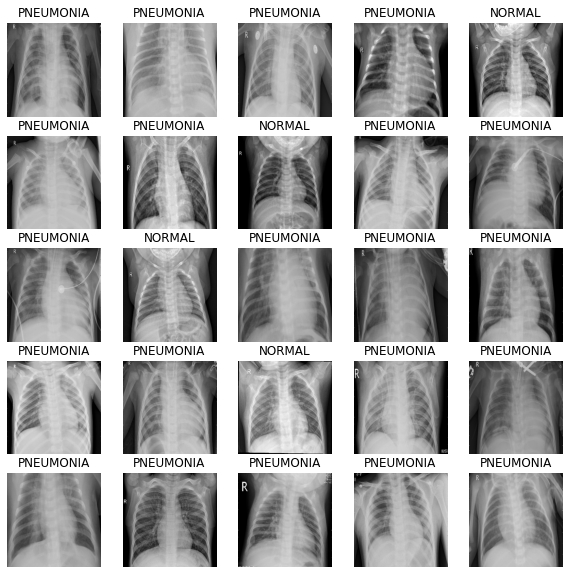

In [30]:
ShowBatch()

# 4. Creating the CNN Model and Fitting it

In [34]:
# Build Training and Validation Datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Pneumonia_Xrays/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Pneumonia_Xrays/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


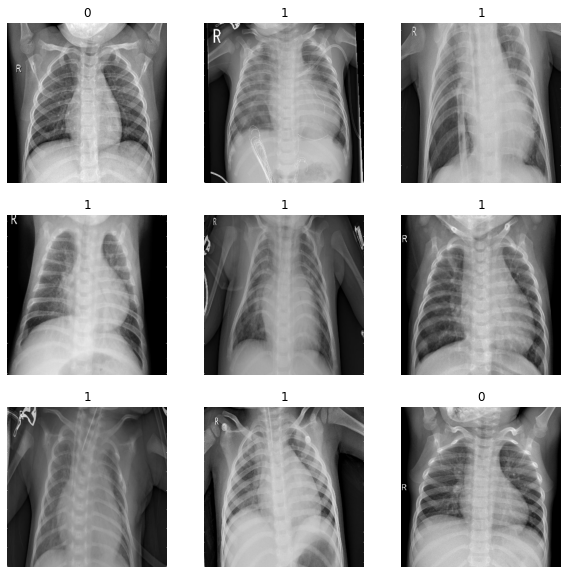

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [38]:
def BuildModel():
  model = tf.keras.models.Sequential([
    
      # Note the input shape is the desired size of the image 300x300 with 3 bytes color
      # This is the first convolution
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
    
      # The second convolution
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
    
      # The third convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
    
      # The fourth convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
    
      # The fifth convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

    
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'), # 512 neuron hidden layer
      # Only 1 output neuron. It will contain a value from 0-1 where 0 for ('normal') clas and 1 for ('pneumonia') class
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  return model

  


In [39]:
# Defining Metrics and Optimizations parameters
model=BuildModel()
METRICS=[
         'accuracy',
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
         
]
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=METRICS
)

In [40]:

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weights,
)


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/25
167/167 [==============================] - 860s 5s/step - loss: 0.5200 - accuracy: 0.8399 - precision: 0.9441 - recall: 0.8339 - val_loss: 0.1529 - val_accuracy: 0.9444 - val_precision: 0.9972 - val_recall: 0.9277
Epoch 2/25
167/167 [==============================] - 411s 2s/step - loss: 0.0513 - accuracy: 0.9504 - precision: 0.9849 - recall: 0.9477 - val_loss: 0.0834 - val_accuracy: 0.9674 - val_precision: 0.9744 - val_recall: 0.9819
Epoch 3/25
167/167 [==============================] - 413s 2s/step - loss: 0.0424 - accuracy: 0.9571 - precision: 0.9860 - recall: 0.9558 - val_loss: 0.1642 - val_accuracy: 0.9444 - val_precision: 0.9986 - val_recall: 0.9265
Epoch 4/25
167/167 [==============================] - 412s 2s/step - loss: 0.0680 - accuracy: 0.9351 - precision: 0.9787 - recall: 0.9329 - val_loss: 0.2605 - val_accuracy: 0.9012 - val_p

In [57]:
Test_Files=tf.io.gfile.glob(str(main_path+"/test/*"))
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Pneumonia_Xrays/test/",
    label_mode=None,
    seed=1337,
    image_size=IMAGE_SIZE,
)
#y_predict=model.predict(test_ds)

Found 624 files belonging to 1 classes.


In [66]:
loss, acc, prec, rec=model.evaluate(test_ds)
loss, acc, prec, rec

20/20 [==============================] - 4s 117ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00


(0.0, 0.0, 0.0, 0.0)

In [62]:
y_pred=model.predict(test_ds)
y_pred.shape

(624, 1)

In [96]:
y_pred=y_pred>0.5
y_pred=y_pred.astype(int)
y_pred


array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
    

In [107]:
# imgs=np.array(Test_Files)
# test_array=np.zeros(shape=[len(Test_Files),2])
# test_array[:,0]=imgs
test_array=np.array(Test_Files,ndmin=2).T
vals=np.array(y_pred,ndmin=2)
test_array=np.append(test_array,vals,axis=1)
df=pd.DataFrame(data=test_array,columns=["Id","Category"])
df

,Id,Category
0,/content/drive/My Drive/Pneumonia_Xrays//test/...,1
1,/content/drive/My Drive/Pneumonia_Xrays//test/...,1
2,/content/drive/My Drive/Pneumonia_Xrays//test/...,1
3,/content/drive/My Drive/Pneumonia_Xrays//test/...,1
4,/content/drive/My Drive/Pneumonia_Xrays//test/...,1
...,...,...
619,/content/drive/My Drive/Pneumonia_Xrays//test/...,1
620,/content/drive/My Drive/Pneumonia_Xrays//test/...,1
621,/content/drive/My Drive/Pneumonia_Xrays//test/...,1
622,/content/drive/My Drive/Pneumonia_Xrays//test/...,1


In [108]:
df=df.set_index("Id")
df.to_csv("submission.csv")
%pwd

'/content/drive/My Drive/Pneumonia_Xrays'

In [52]:
img = keras.preprocessing.image.load_img(
    "/content/drive/My Drive/Pneumonia_Xrays/test/00623.jpeg", target_size=IMAGE_SIZE
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 0.00 percent cat and 100.00 percent dog.
